In [ ]:
## CELL 1: Setup and Model Definition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Load and Preprocess Data (MNIST) ---
print("Loading and preparing MNIST data...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape
x_test = x_test.astype('float32') / 255.0
# Add channel dimension: (N, 28, 28) -> (N, 28, 28, 1)
x_test = np.expand_dims(x_test, -1)
input_shape = x_test.shape[1:]

# --- 2. Define the CNN Architecture ---
def create_cnn_model(input_shape):
    model = Sequential([
        # Layer 1: Conv2D -> Pooling
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv_1'),
        MaxPooling2D(pool_size=(2, 2), name='pool_1'),

        # Layer 2: Conv2D -> Pooling
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(2, 2), name='pool_2'),

        # Layer 3: Conv2D -> Pooling
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', name='conv_3'),
        MaxPooling2D(pool_size=(2, 2), name='pool_3'),

        # Transition to Dense Layers
        Flatten(name='flatten'),

        # Dense Layers
        Dense(units=128, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='output') # 10 classes for MNIST
    ])
    return model

model = create_cnn_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n--- Model Architecture Summary ---")
model.summary()

# --- 3. Train the model (Optional, but recommended for meaningful features) ---
# For demonstration, we'll train on a small subset for a few epochs.
x_train_small, y_train_small = x_train[:10000], y_train[:10000]
x_train_small = np.expand_dims(x_train_small.astype('float32') / 255.0, -1)

print("\nTraining small subset (5 epochs) for feature learning...")
model.fit(x_train_small, y_train_small, epochs=5, batch_size=64, verbose=0)
print("Training complete.")

Loading and preparing MNIST data...

--- Model Architecture Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)


Training small subset (5 epochs) for feature learning...
Training complete.


In [ ]:
## CELL 2: Feature Map Visualization Function

def visualize_feature_maps(model, image, layer_names):
    """
    Creates and predicts with a sub-model to get activations, then plots them.
    """
    # Ensure the model is built, primarily to get `model.input_shape`.
    # The previous attempt to call model(dummy_input) might not fully populate `model.input`
    # in a way compatible with `tf.keras.Model` constructor for Sequential models in Keras 3.x.
    if not model.built:
        dummy_input_shape = (1,) + model.input_shape[1:]
        dummy_input = tf.zeros(dummy_input_shape, dtype=tf.float32)
        _ = model(dummy_input)

    # Create a new Input layer that matches the model's expected input shape.
    input_tensor = tf.keras.Input(shape=model.input_shape[1:])

    # Create a list to hold the outputs of the desired layers, generated from the new input_tensor.
    outputs_to_extract = []

    # Iterate through the original model's layers, applying them to the new input_tensor.
    # This effectively creates a functional graph using the original Sequential model's layers.
    current_tensor = input_tensor
    for layer in model.layers:
        current_tensor = layer(current_tensor) # Pass the tensor through the layer
        if layer.name in layer_names:
            outputs_to_extract.append(current_tensor)

    # Create the functional model for activation extraction using the explicit input_tensor
    # and the collected intermediate output tensors.
    activation_model = Model(inputs=input_tensor, outputs=outputs_to_extract)

    # Predict the outputs for the single input image (requires batch dim)
    activations = activation_model.predict(np.expand_dims(image, axis=0))

    for layer_name, activation in zip(layer_names, activations):
        # Activation shape is (1, H, W, Filters)
        num_features = activation.shape[-1]

        # Calculate grid size for plotting (e.g., 6x6 for 32 features, 8x8 for 64)
        cols = int(np.ceil(np.sqrt(num_features)))
        rows = int(np.ceil(num_features / cols))

        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        fig.suptitle(f'Feature Maps from Layer: {layer_name}\n(Shape: {activation.shape[1]}x{activation.shape[2]}x{activation.shape[3]})',
                     fontsize=16)

        print(f"Layer: {layer_name} | Output Shape: {activation.shape[1:]} | Feature Maps: {num_features}")

        # Plot each feature map
        for i in range(num_features):
            ax = axes.flat[i]
            # Get the feature map for the i-th filter (it's a 2D array)
            feature_map = activation[0, :, :, i]
            # Normalize for better visualization (important for deep layers)
            feature_map = (feature_map - feature_map.mean()) / (feature_map.std() + 1e-5)
            feature_map *= 64
            feature_map += 128
            feature_map = np.clip(feature_map, 0, 255).astype('uint8')

            ax.matshow(feature_map, cmap='viridis')
            ax.set_title(f'Feature {i+1}', fontsize=8)
            ax.axis('off')

        # Hide any unused subplots
        for j in range(num_features, rows * cols):
            if j < len(axes.flat):
                axes.flat[j].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# --- 3. Function to Visualize Learned Kernels (Filters) ---
def visualize_kernels(model, layer_name, num_to_show=16):
    """Plots the actual weights (kernels) learned by a Conv2D layer."""
    try:
        # Weights are stored as [kernel_height, kernel_width, input_channels, output_channels (filters)]
        weights = model.get_layer(layer_name).get_weights()[0]
    except ValueError:
        print(f"Layer {layer_name} is not a Conv2D layer or has no weights.")
        return

    n_filters = weights.shape[-1]
    n_filters = min(n_filters, num_to_show)

    fig, axes = plt.subplots(1, n_filters, figsize=(n_filters * 1.5, 2))
    fig.suptitle(f'Learned Kernels (Weights) for Layer: {layer_name}', fontsize=16)

    for i in range(n_filters):
        # We only have 1 input channel for MNIST, so we grab the first channel of the kernel
        kernel = weights[:, :, 0, i]
        ax = axes[i]

        # Normalize weights for visualization
        kernel_norm = (kernel - kernel.min()) / (kernel.max() - kernel.min())

        ax.imshow(kernel_norm, cmap='gray')
        ax.set_title(f'Kernel {i+1}', fontsize=8)
        ax.axis('off')

    plt.show()

--- Input Image (Label: 6) ---


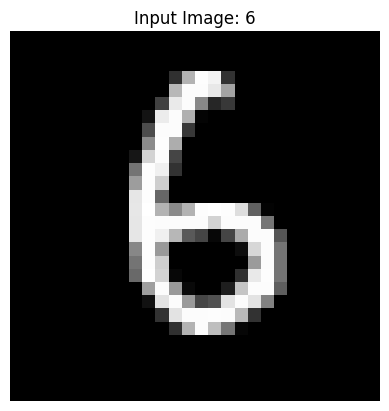


### 1. Visualization of Kernels (What the layer *looks* for) ###


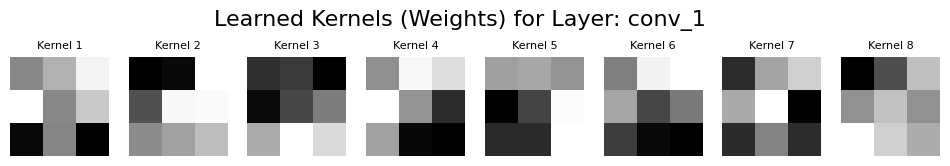


### 2. Visualization of Feature Maps (What the layer *found*) ###
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Layer: conv_1 | Output Shape: (26, 26, 32) | Feature Maps: 32


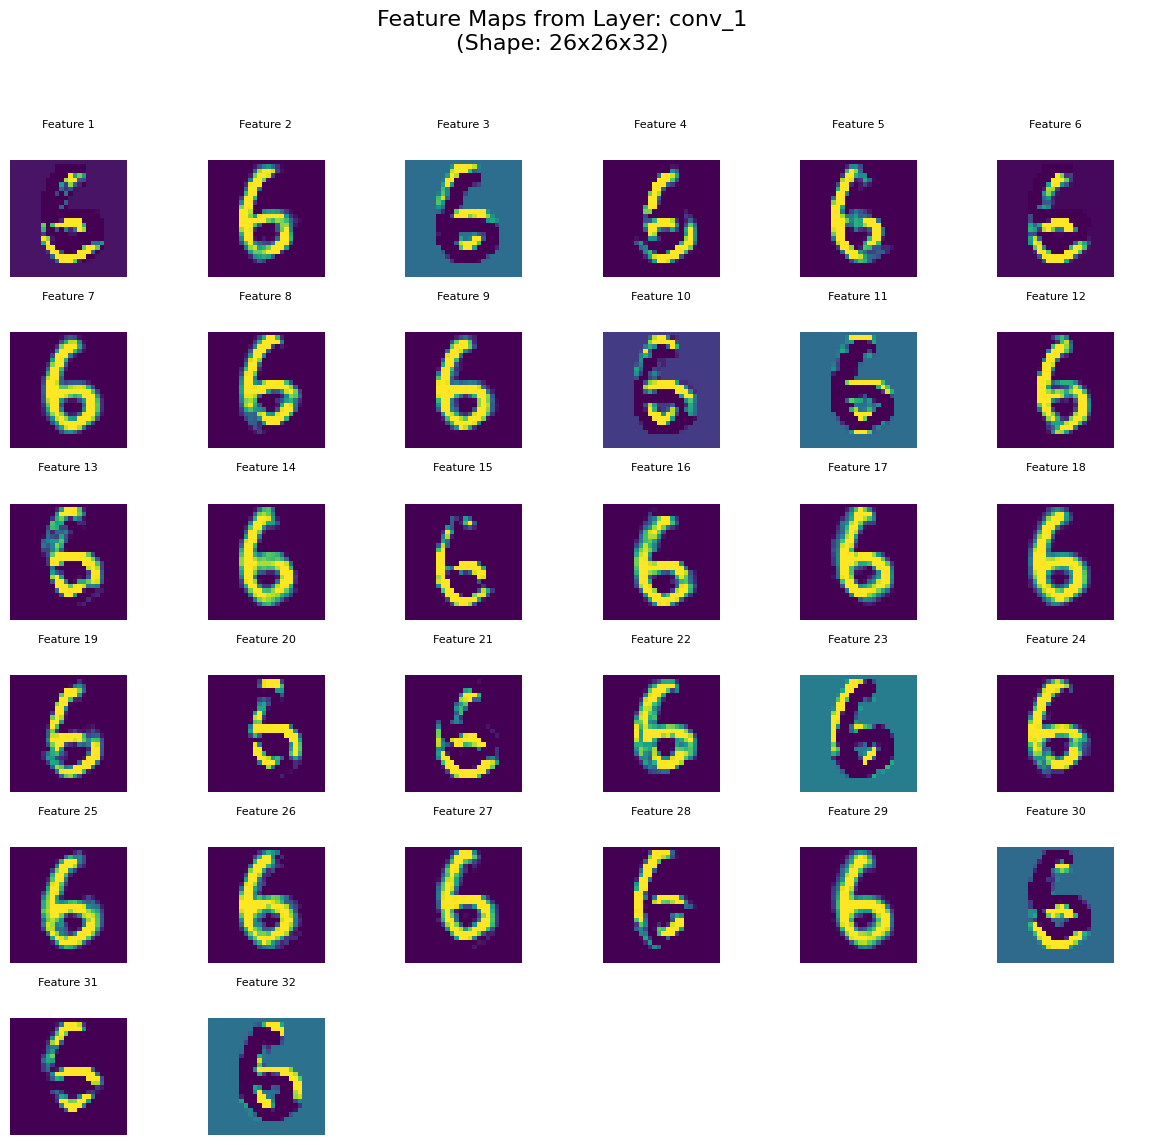

Layer: pool_1 | Output Shape: (13, 13, 32) | Feature Maps: 32


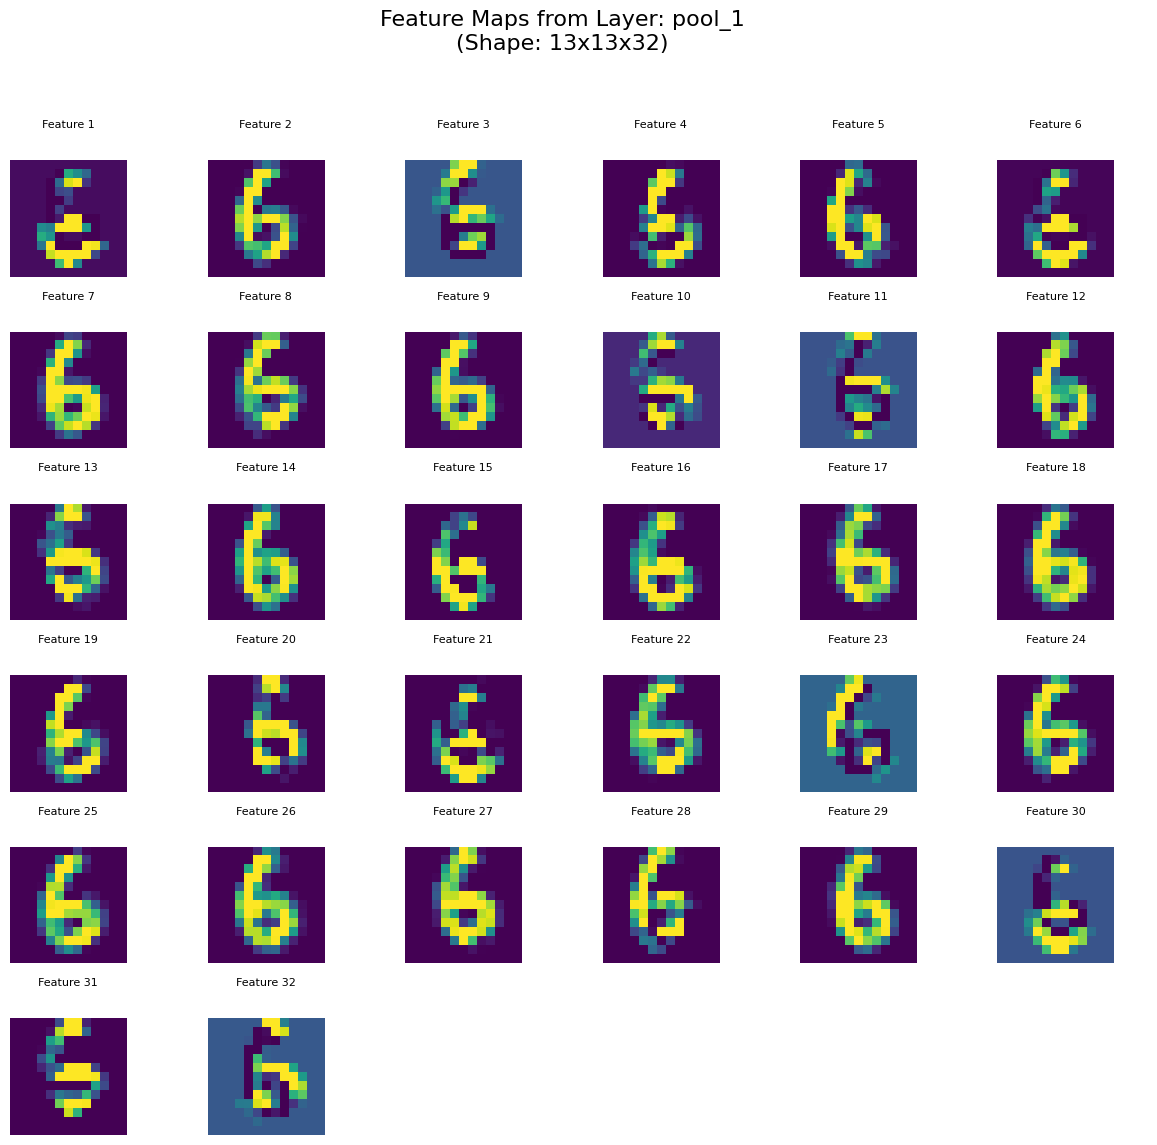

Layer: conv_2 | Output Shape: (11, 11, 64) | Feature Maps: 64


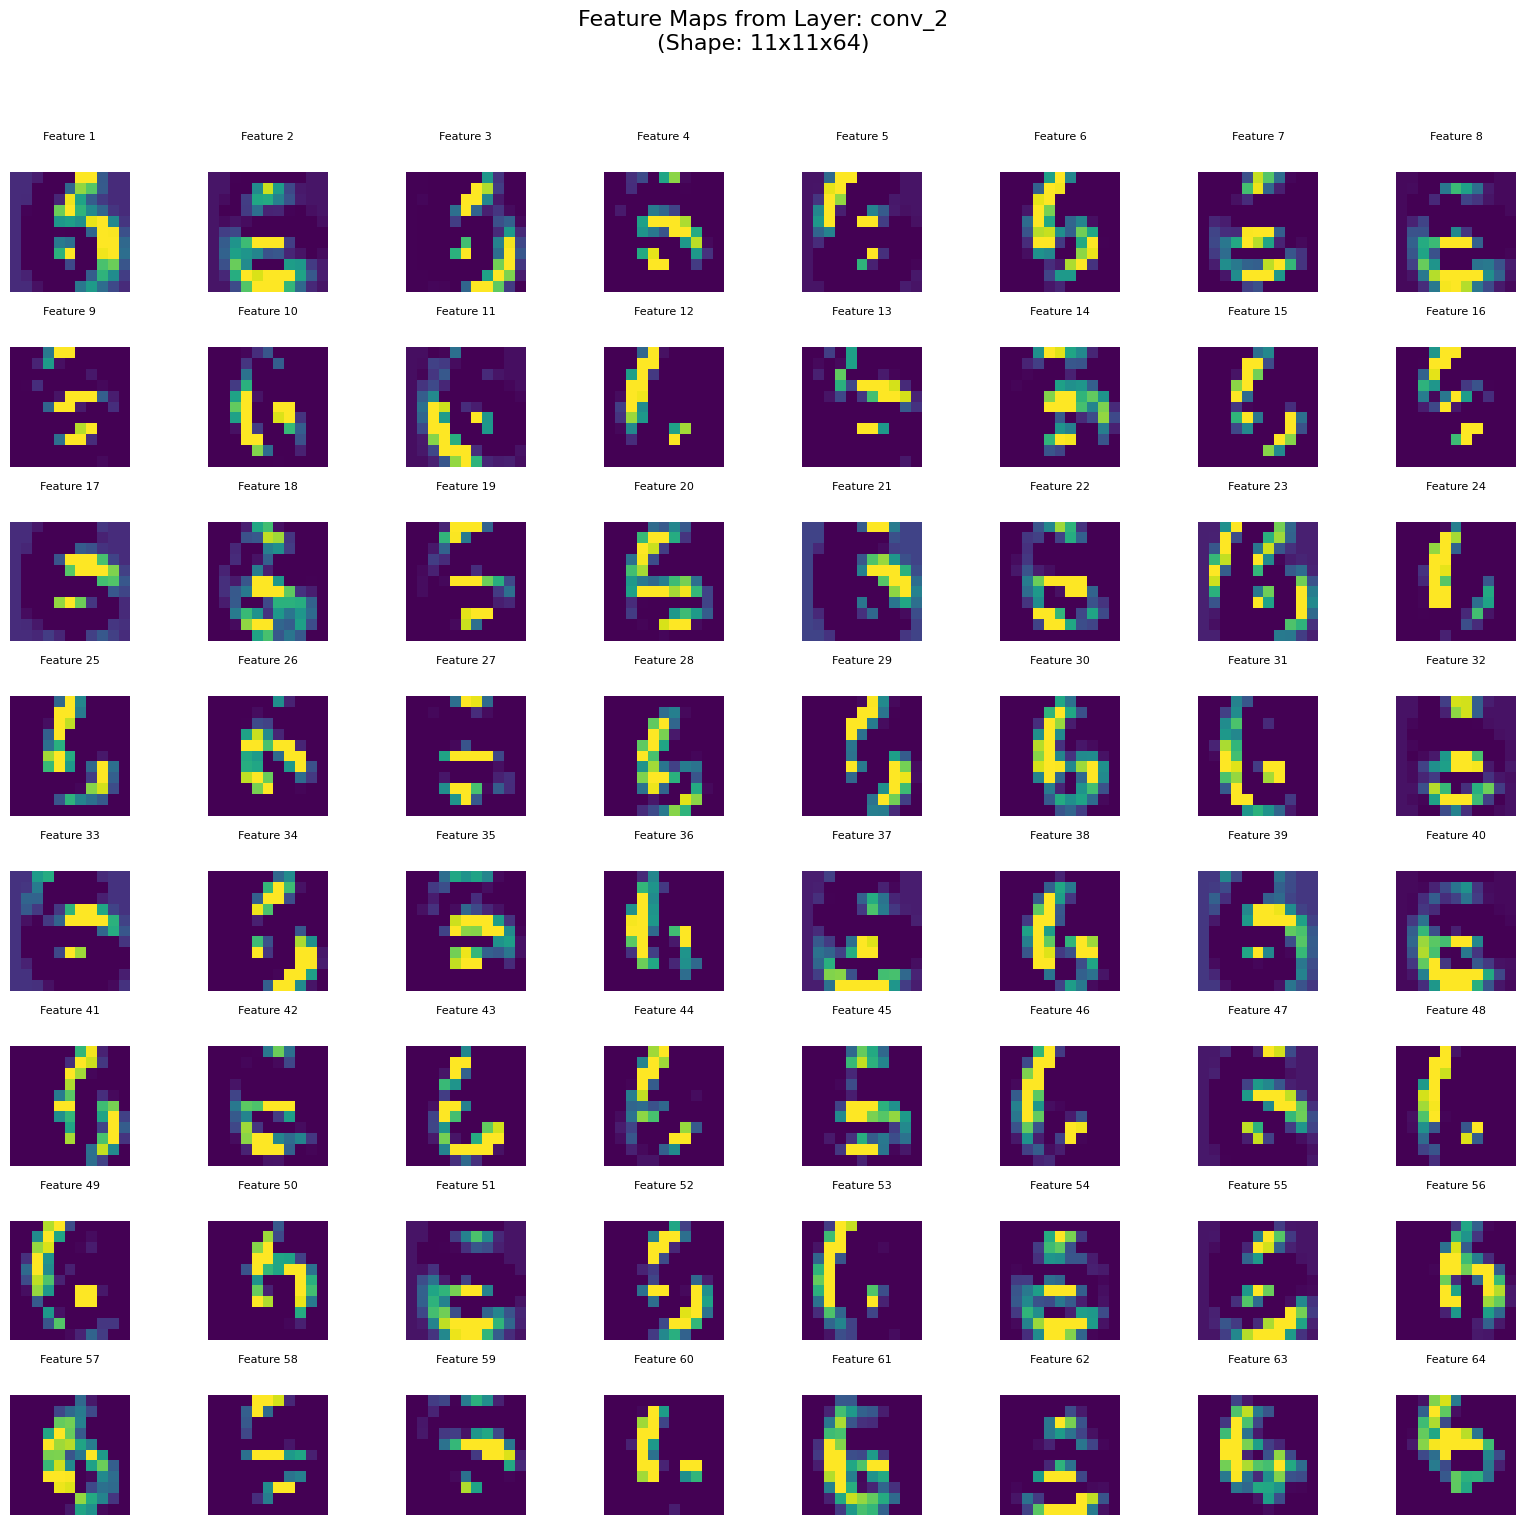

Layer: pool_2 | Output Shape: (5, 5, 64) | Feature Maps: 64


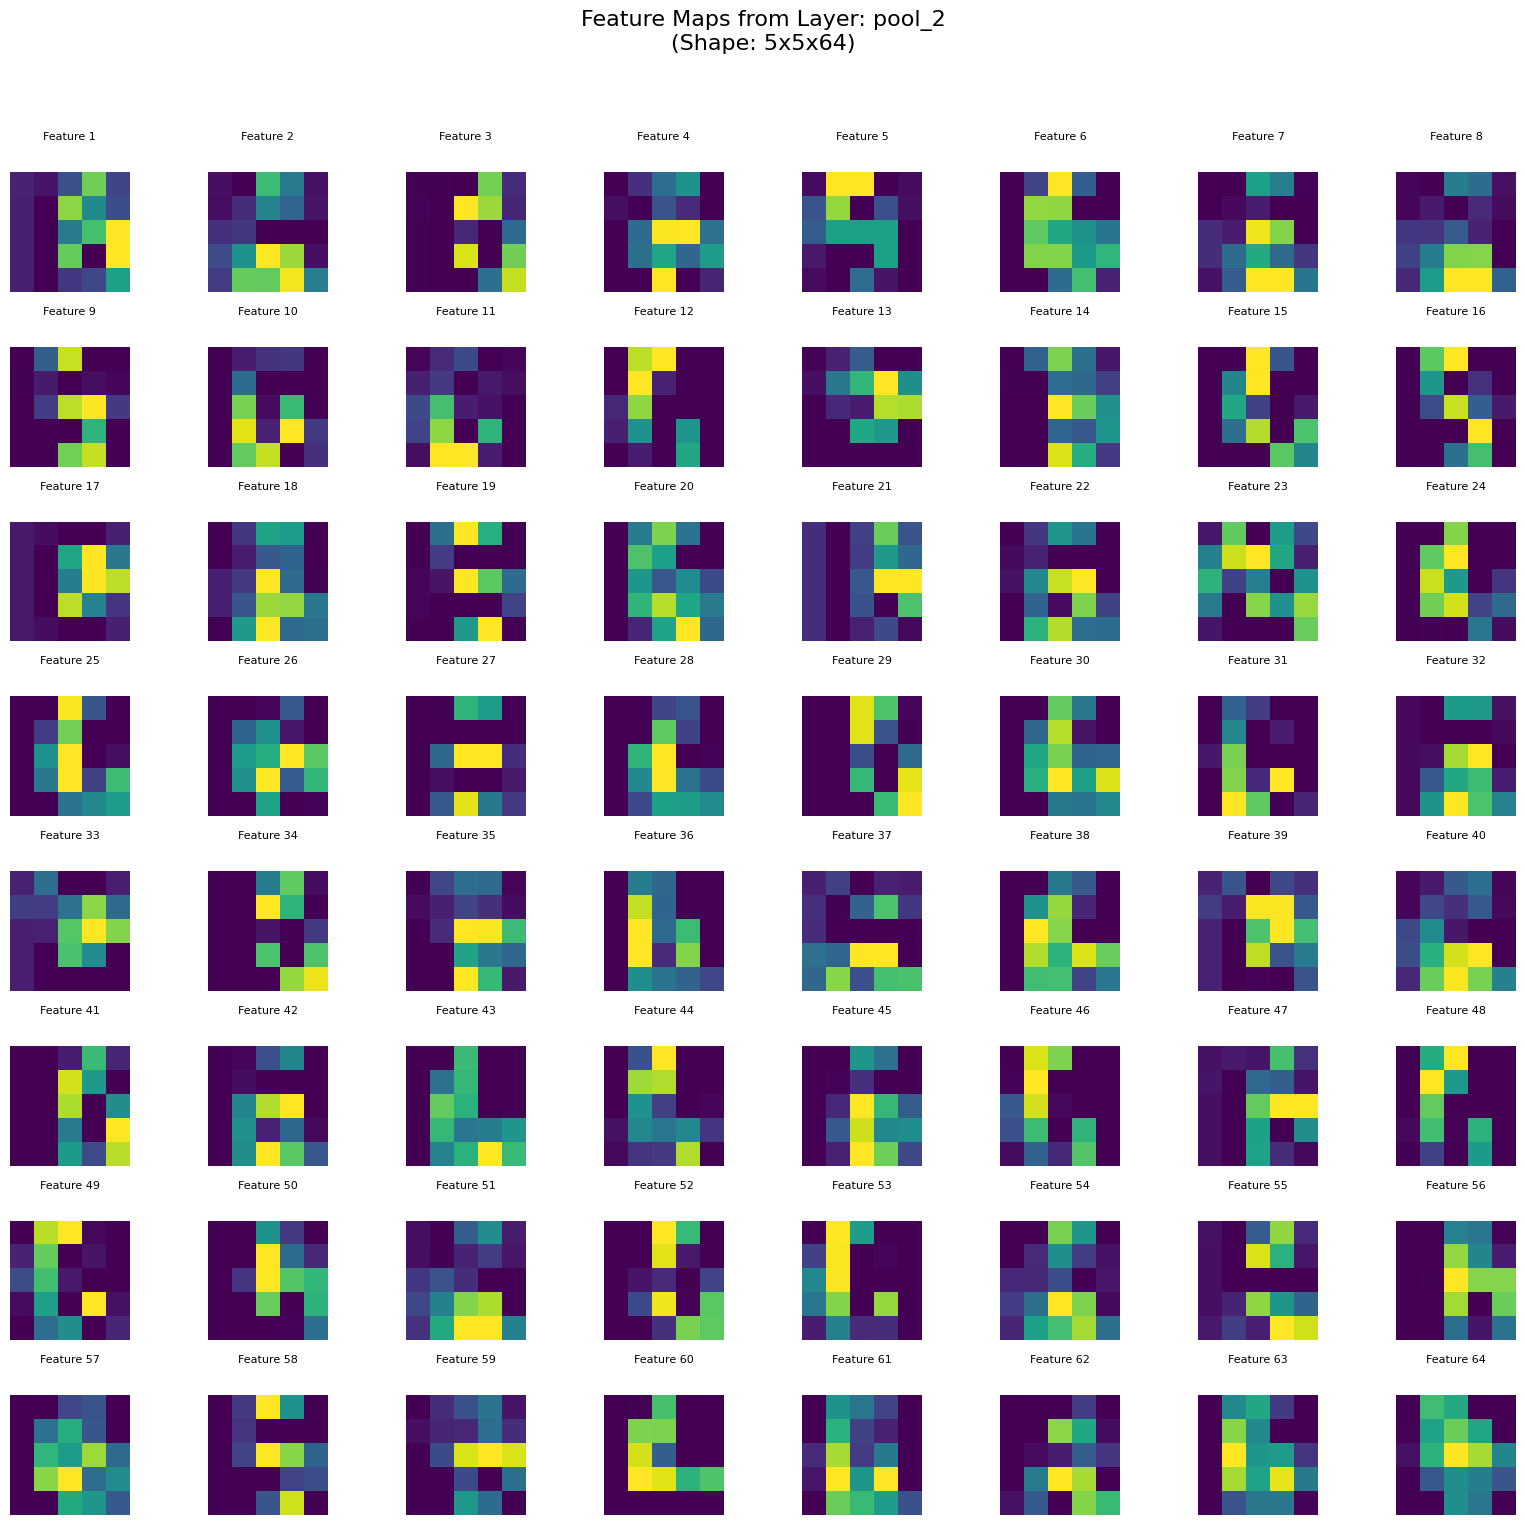

Layer: conv_3 | Output Shape: (3, 3, 128) | Feature Maps: 128


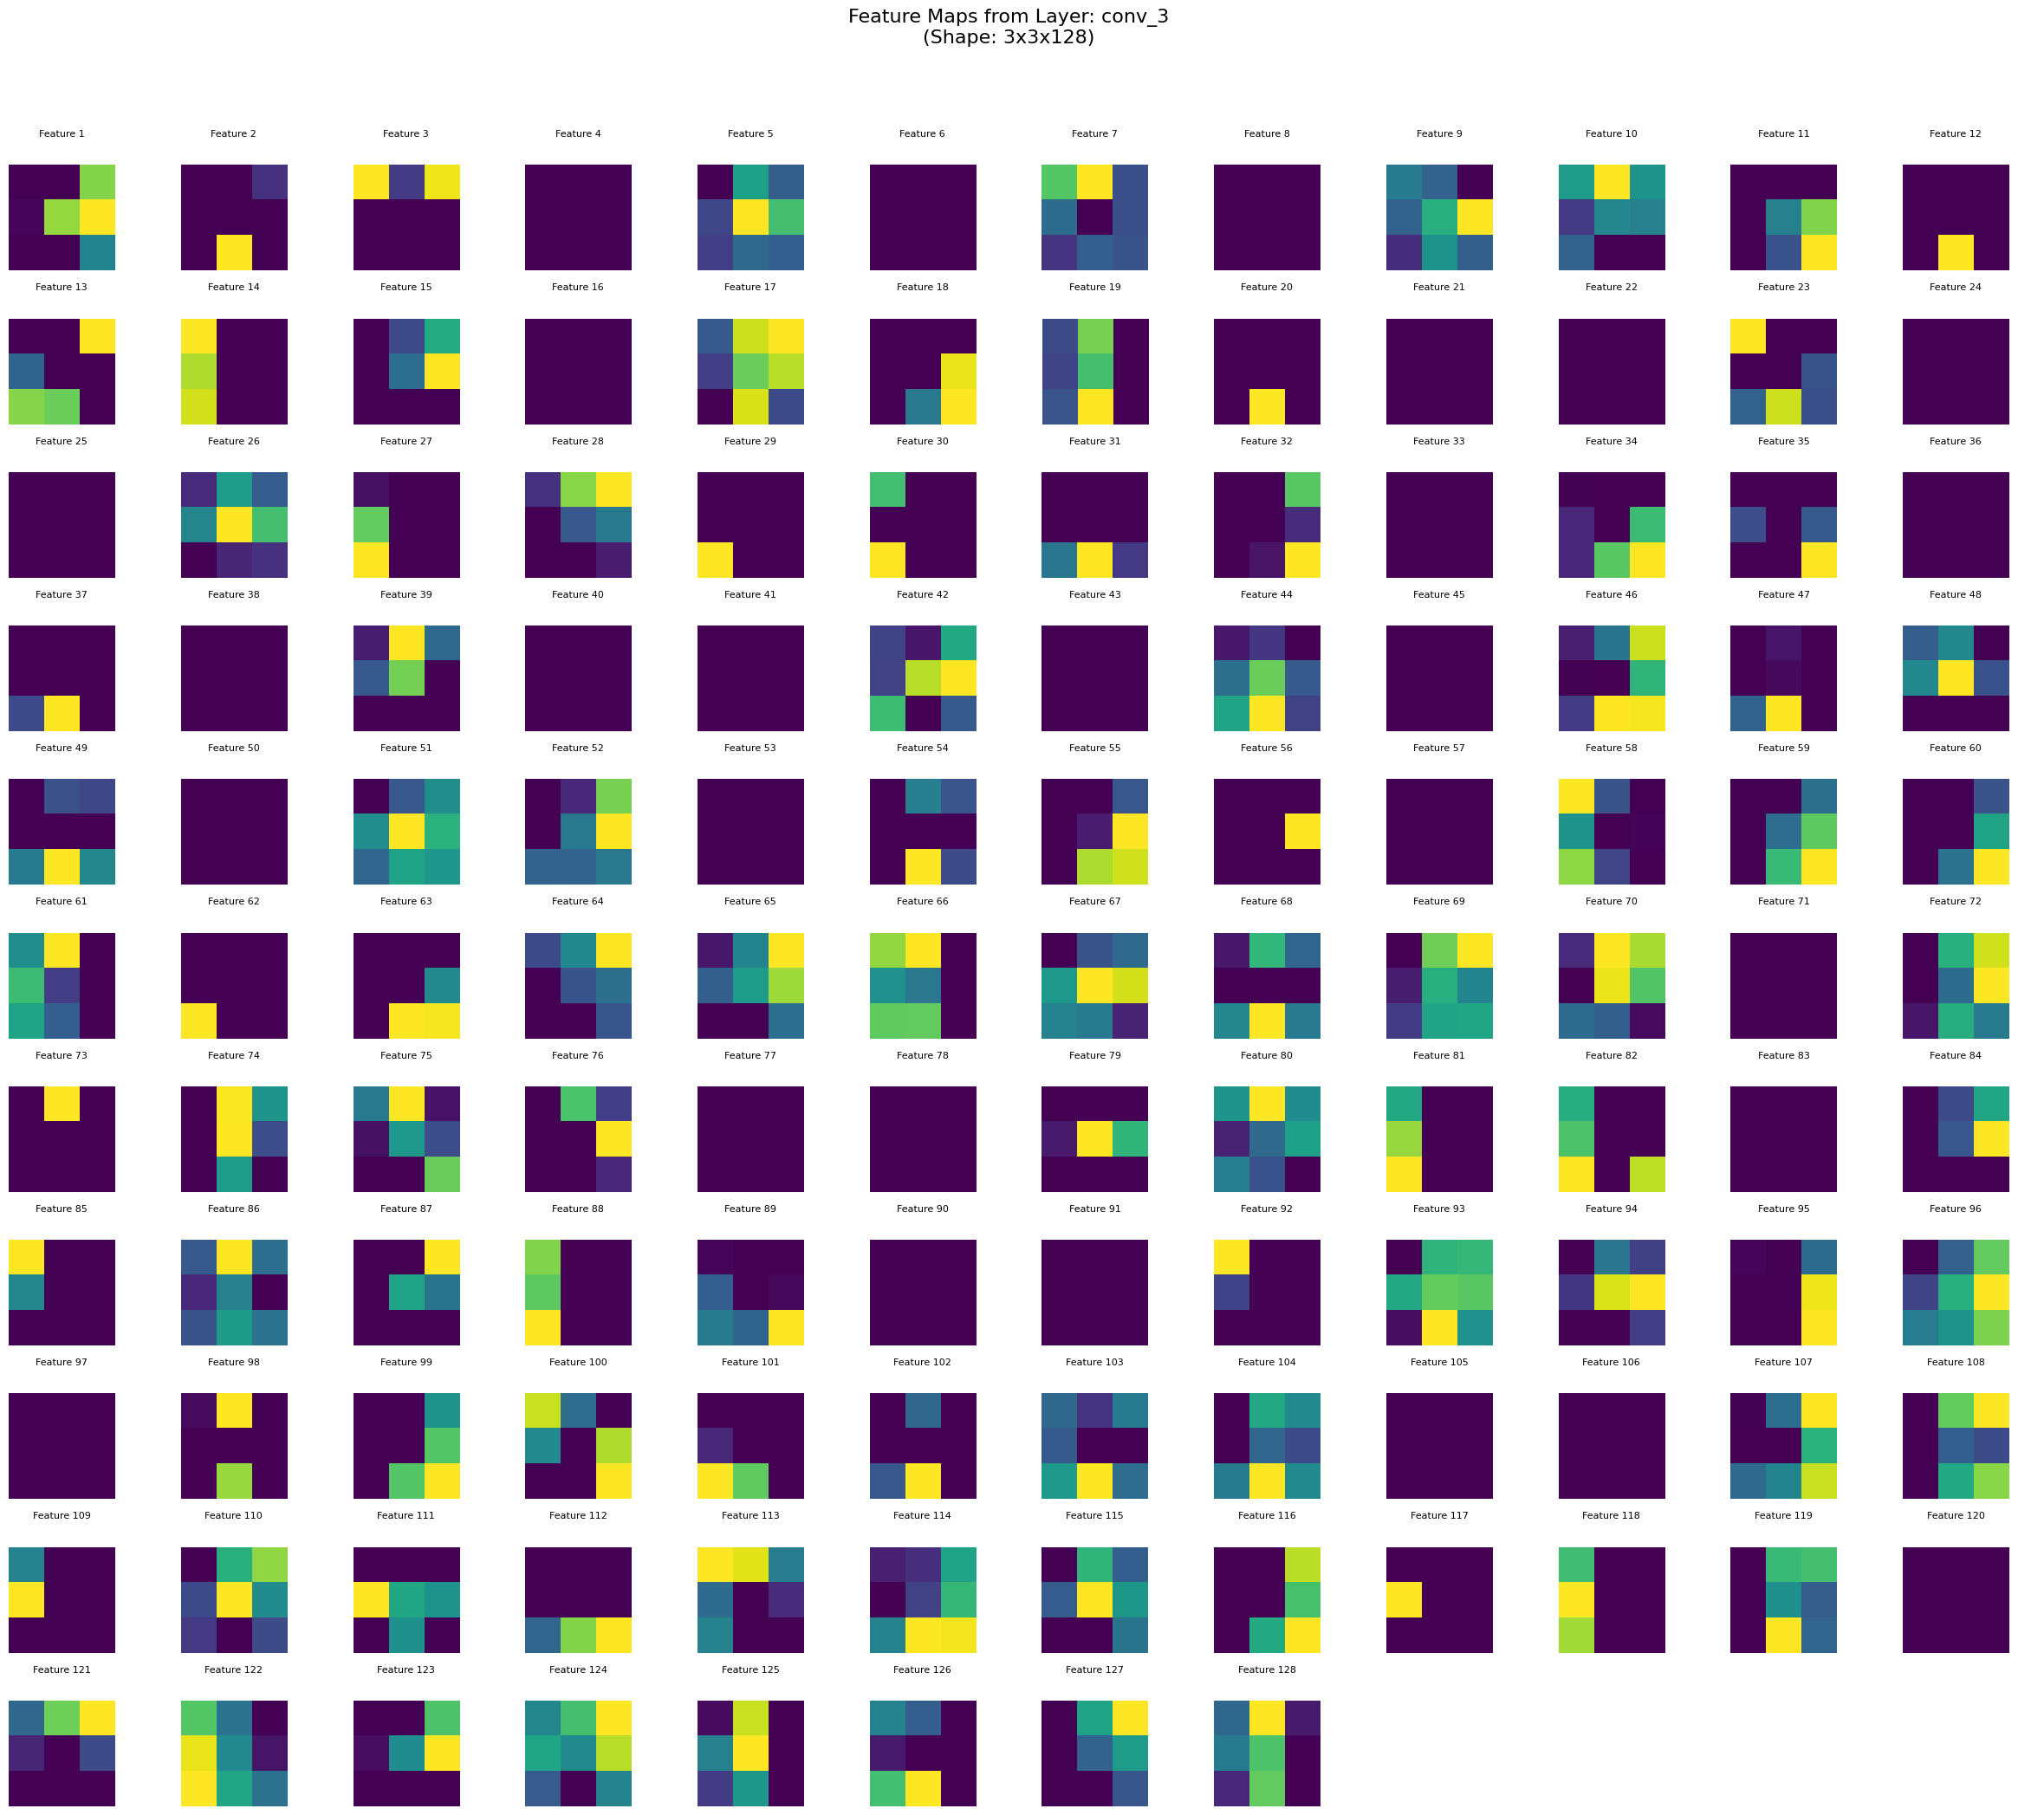

Layer: pool_3 | Output Shape: (1, 1, 128) | Feature Maps: 128


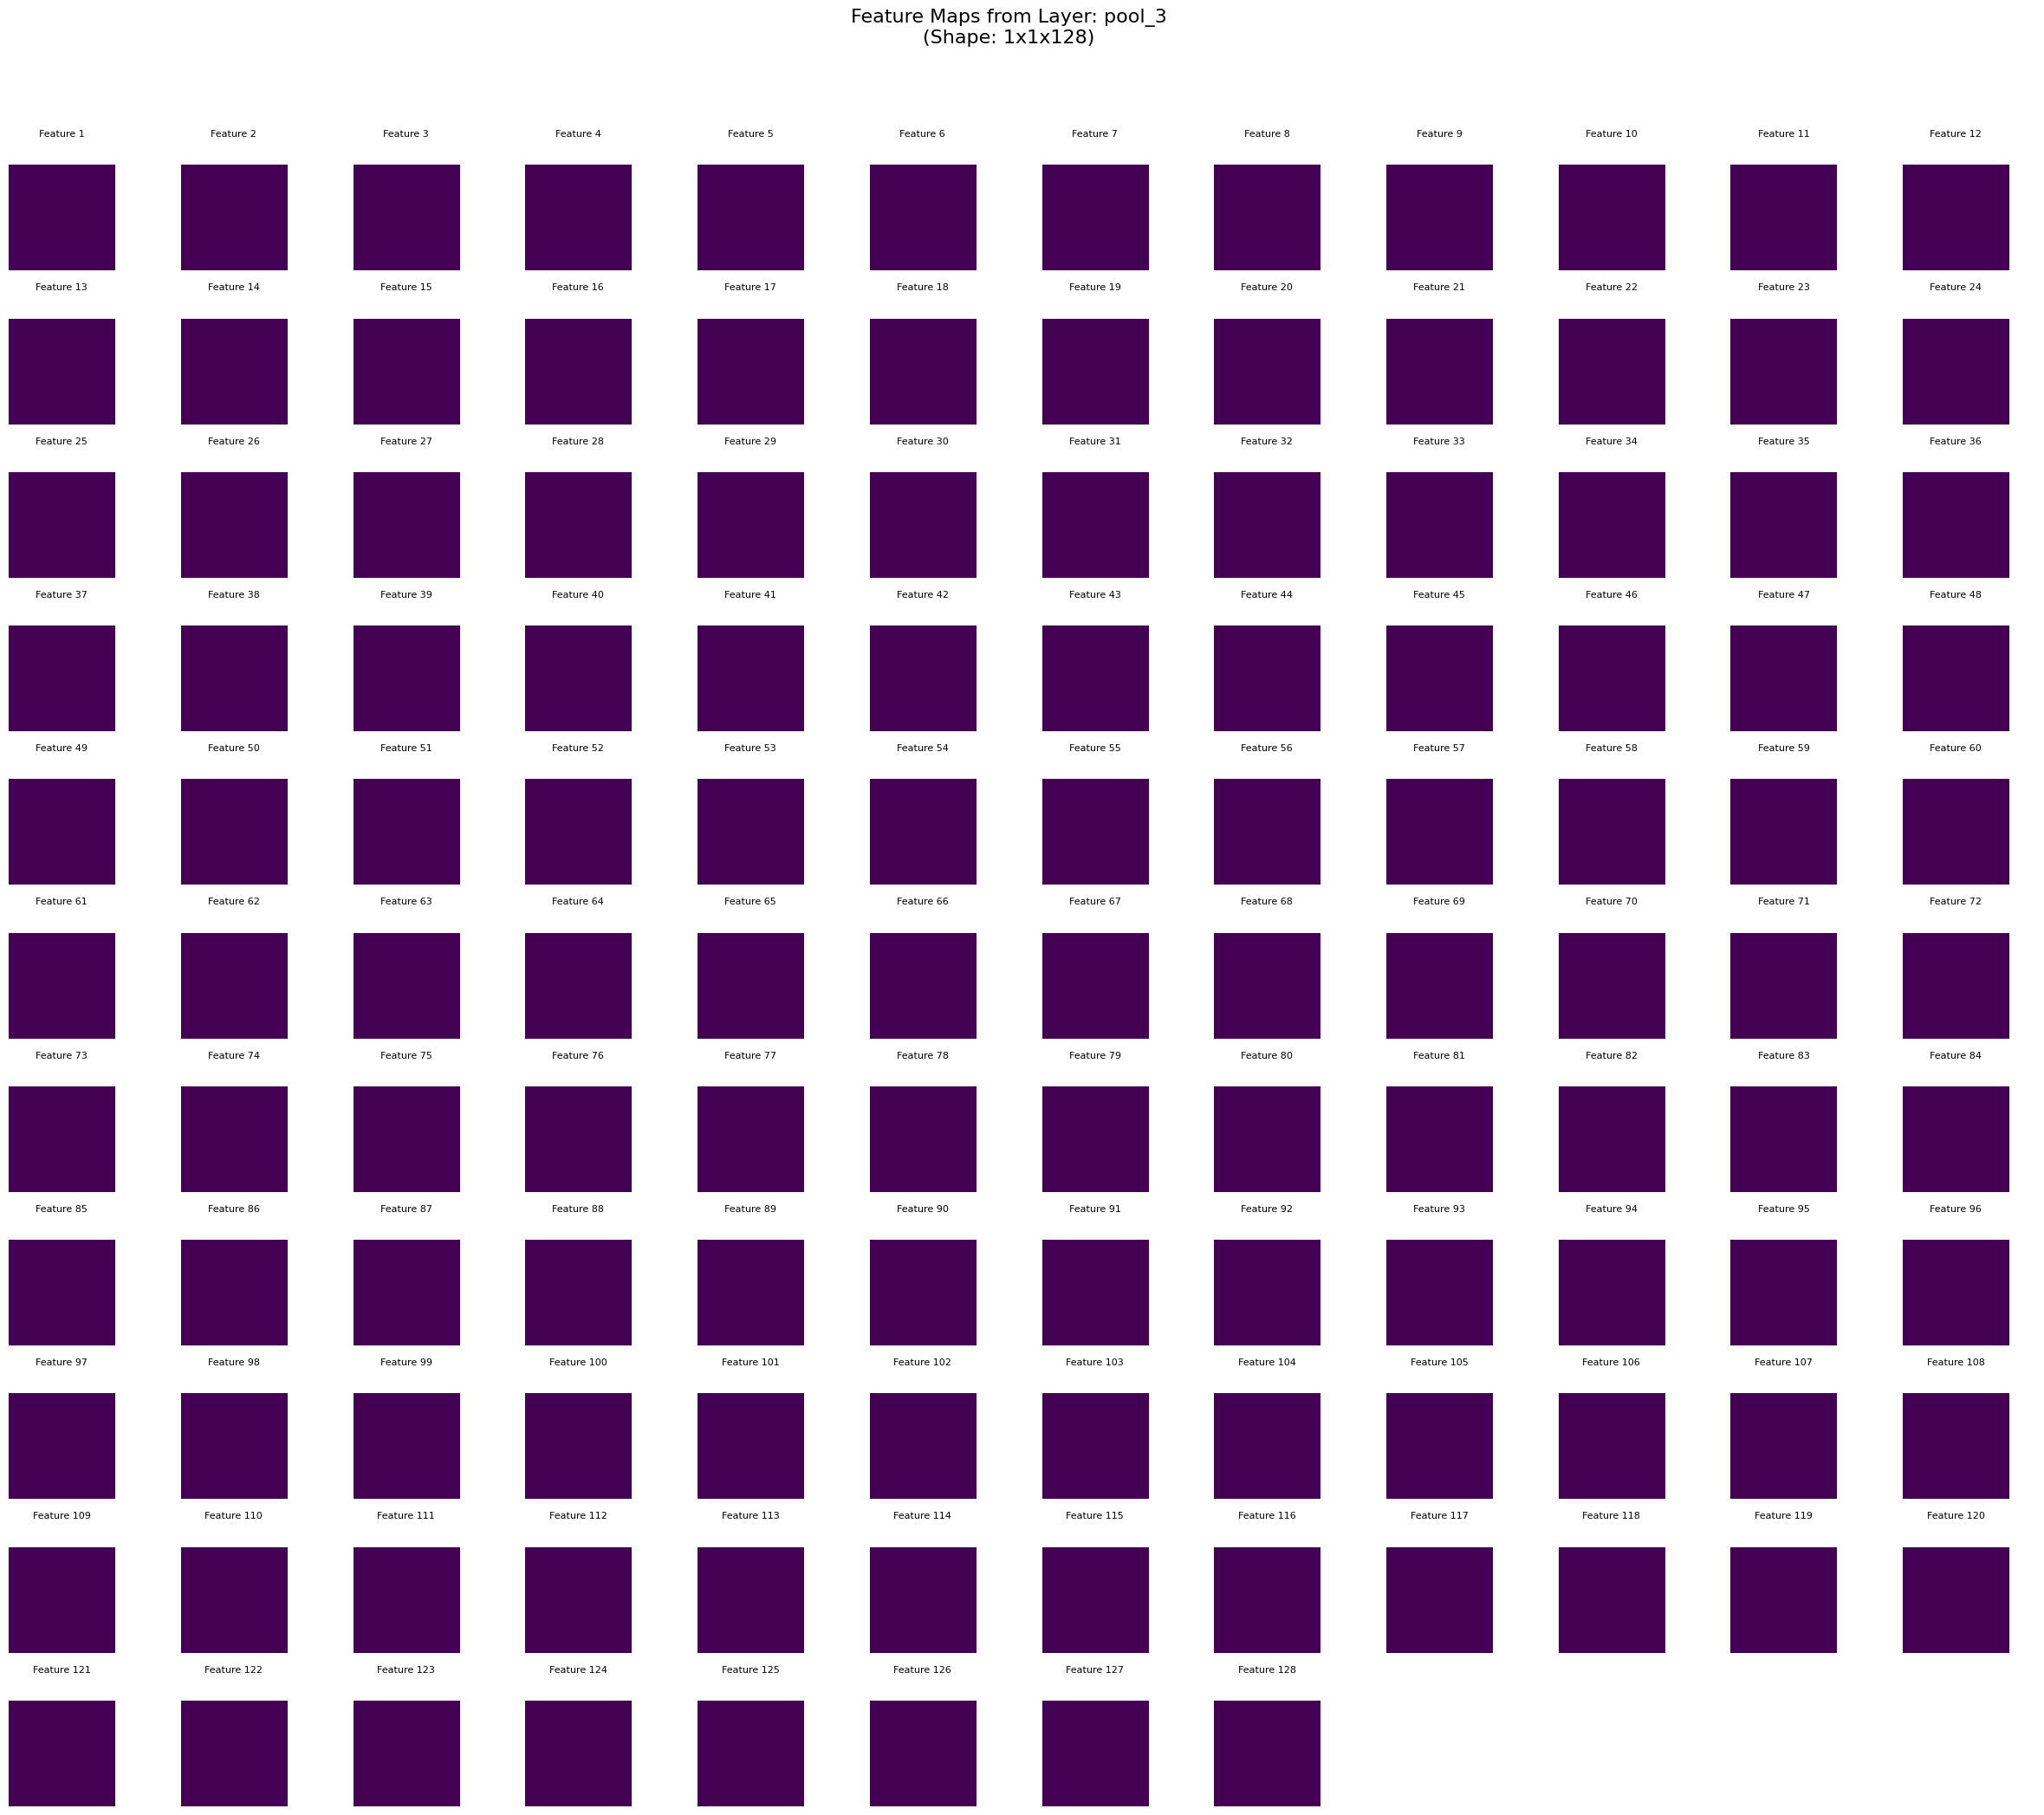

In [ ]:
## CELL 3: Execution and Visualization

# --- Choose a sample image for demonstration ---
#sample_index = 8 # A sample 5
sample_index = 21 # A sample 5
sample_image = x_test[sample_index]
true_label = y_test[sample_index]

print(f"--- Input Image (Label: {true_label}) ---")
plt.imshow(sample_image[:, :, 0], cmap='gray')
plt.title(f"Input Image: {true_label}")
plt.axis('off')
plt.show()



# --- A. Visualize Learned Kernels (Effect of Filters) ---
print("\n### 1. Visualization of Kernels (What the layer *looks* for) ###")
# Show the 32 kernels of the first layer
visualize_kernels(model, 'conv_1', num_to_show=8)


# --- B. Visualize Feature Maps (Intermediate Activations) ---
print("\n### 2. Visualization of Feature Maps (What the layer *found*) ###")

# List of layers to visualize
layer_names_to_visualize = [
    'conv_1',  # First Conv Layer (32 Feature Maps)
    'pool_1',  # First Pool Layer (32 Feature Maps)
    'conv_2',  # Second Conv Layer (64 Feature Maps)
    'pool_2',  # Second Pool Layer (64 Feature Maps)
    'conv_3',  # Third Conv Layer (128 Feature Maps)
    'pool_3'   # Third Pool Layer (128 Feature Maps)
]

# Run the visualization function
visualize_feature_maps(model, sample_image, layer_names_to_visualize)